In [237]:
import pandas as pd
import numpy as np
import seaborn as sns
import treeswift
import math
import re

In [391]:
%load_ext autoreload
%autoreload 2
    
import helpers.utils
from helpers.utils import build_summary_df
from helpers.utils import plot_genotype_confidence
from helpers.utils import clustermap_genos
from helpers.utils import distdict_to_df, leaf_pairs, get_geno_dict
from helpers.utils import im_ehd, empirical_site_dists, ehd, sm_ehd, pair_metrics
from helpers.utils import plot_concordance_scatterplot, plot_concordance_distribution
from helpers.utils import plot_state_counts, report_genotype_call_stats, save_df_to_pdf
from helpers.utils import plot_correlation, plot_bl_variance, add_internal_labels, branch_table
from helpers.utils import plot_tree_3d, edge_ratio_table, plot_genotype_panels

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Remember not to re-run the process petracer code... it reshuffles the cell names!

I subset to clone 2 after I assigned the target_idx, so I have to remap the character_idx and target_idx. 

In [167]:
# import sys
# sys.path.insert(0, "/Users/gc3045/git/fast-laml/scripts") 
# import euclidean_solver as es

In [171]:
inputs_basename = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/"
lamlpro_prefix = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/outputs_petracer_seq_validation_clone2/fastlaml_clone2.neighbor_joining"

In [172]:
lp_input_argmax = inputs_basename + "petracer_clone2_kde_character_matrix.csv"
bm_input_geno = inputs_basename + "petracer_clone2_petracer_genotypes.csv"
all_bm_input_geno = inputs_basename + "petracer_full_training.csv"
lp_map_geno = lamlpro_prefix + "_posterior_argmax.csv"

bm_treefile = inputs_basename + "trees/seq_validation/clone2.neighbor_joining.nwk"
lp_treefile = lamlpro_prefix + "_tree.newick"

In [173]:
lp_input_geno = inputs_basename + "/petracer_clone2_kde_scores.csv"

#### Read inputs

In [174]:
lp_input_argmax_df = pd.read_csv(lp_input_argmax)

In [180]:
label_codebook = pd.read_csv(inputs_basename + "/label_codebook.csv")

In [181]:
label_codebook

,site,label,genotype
0,EMX1,unedited,0
1,EMX1,ACAAT,1
2,EMX1,AGTAC,2
3,EMX1,ATCAA,3
4,EMX1,ATTCG,4
5,EMX1,CCCTA,5
6,EMX1,CCGAT,6
7,EMX1,CCTTT,7
8,EMX1,GGACA,8
9,HEK3,unedited,0


In [182]:
petracer_full_traindf = pd.read_csv(all_bm_input_geno)

In [183]:
lp_input_geno_df = pd.read_csv(lp_input_geno)

In [184]:
bm_input_geno_df = pd.read_csv(bm_input_geno)
lp_map_geno_df = pd.read_csv(lp_map_geno, skiprows=2, index_col=0)

In [188]:
site_lookup = bm_input_geno_df[['target_site', 'target_idx']].drop_duplicates()
site_lookup

,target_site,target_idx
0,HEK3,1
127,HEK3,4
222,HEK3,7
349,HEK3,10
477,HEK3,13
598,HEK3,16
726,HEK3,19
865,HEK3,22
989,HEK3,25
1105,HEK3,28


#### Inspect a single cell as sanity check

In [191]:
lp_map_geno_df.loc['4T1_preedited-35']

character_0    -1
character_1    -1
character_2    -1
character_3    -1
character_4    -1
character_5    -1
character_6    -1
character_7    -1
character_8    -1
character_9    -1
character_10   -1
character_11   -1
character_12   -1
character_13   -1
character_14   -1
character_15   -1
character_16   -1
character_17   -1
character_18    1
character_19    4
character_20    8
character_21    8
character_22    5
character_23    1
character_24   -1
character_25   -1
character_26   -1
character_27   -1
character_28   -1
character_29   -1
character_30   -1
character_31   -1
character_32   -1
character_33   -1
character_34   -1
character_35   -1
character_36    1
character_37    2
character_38    6
character_39    1
character_40    2
character_41    3
character_42   -1
character_43   -1
character_44   -1
character_45   -1
character_46   -1
character_47   -1
character_48    4
character_49    2
character_50    8
character_51   -1
character_52   -1
character_53   -1
character_54    3
character_

In [195]:
mask = bm_input_geno_df['cellBC'] == '4T1_preedited-35'
bm_input_geno_df.loc[mask, ['target_idx', 'pet_geno']].sort_values(by='target_idx')

,target_idx,pet_geno
5644,18,1
772,19,4
3208,20,0
5777,21,8
905,22,5
3341,23,1
6389,36,1
1517,37,2
3953,38,6
6500,39,1


### For all cells now, compute accuracy

In [203]:
cells = [cell for cell in lp_map_geno_df.index if not cell.startswith('internal_')]

In [204]:
lp_map_geno_df = lp_map_geno_df.loc[cells]

In [215]:
lp_map_geno_df.columns = [col.split('_')[1] for col in lp_map_geno_df.columns]

In [216]:
pet_geno = bm_input_geno_df[['cellBC', 'target_idx', 'pet_geno']].pivot(index='cellBC', columns='target_idx', values='pet_geno').fillna(-1).astype('int').reindex(lp_map_geno_df.index)
brightest_geno = bm_input_geno_df[['cellBC', 'target_idx', 'brightest_geno']].pivot(index='cellBC', columns='target_idx', values='brightest_geno').fillna(-1).astype('int').reindex(lp_map_geno_df.index)
seq_geno = bm_input_geno_df[['cellBC', 'target_idx', 'seq_geno']].pivot(index='cellBC', columns='target_idx', values='seq_geno').fillna(-1).astype('int').reindex(lp_map_geno_df.index)

In [218]:
lp = lp_map_geno_df.apply(pd.to_numeric, errors='coerce')
pet = pet_geno.apply(pd.to_numeric, errors='coerce')
seq = seq_geno.apply(pd.to_numeric, errors='coerce')
bright = brightest_geno.apply(pd.to_numeric, errors='coerce')


In [275]:
def compute_accuracy(lp_df, other_df, name):
    # Align shapes/indexes/columns
    # lp_df, other_df = lp_df.align(other_df, join="inner", axis=1)
    lp_vals = lp_df.to_numpy()
    other_vals = other_df.to_numpy()

    mask_valid = (lp_vals != -1) & (other_vals != -1)
    n_total = lp_vals.size
    n_valid = mask_valid.sum()
    mask_imputed = (lp_vals != -1) & (other_vals == -1)
    n_imputed = mask_imputed.sum()

    total_acc = np.mean(lp_vals == other_vals)
    true_agree = ( (lp_vals == other_vals) & mask_valid ).sum() / n_valid if n_valid > 0 else np.nan
    true_disagree = ( (lp_vals != other_vals) & mask_valid ).sum() / n_valid if n_valid > 0 else np.nan

    print(f"--- {name} ---")
    print(f"Total accuracy:     {total_acc:.4f}")
    print(f"True agree (valid): {true_agree:.4f}")
    print(f"True disagree:      {true_disagree:.4f}")
    print(f"N valid:            {n_valid}")
    print(f"N imputed:          {n_imputed}\n")

    return {"method": name,
            "total_acc": total_acc,
            "true_agree": true_agree,
            "true_disagree": true_disagree}

In [276]:
results = []
results.append(compute_accuracy(pet, seq, "PETracer vs. Sequencing"))
results.append(compute_accuracy(lp, seq, "LAML-Pro vs. Sequencing"))
results.append(compute_accuracy(bright, seq, "Brightest vs. Sequencing"))

acc_df = pd.DataFrame(results).set_index("method")
acc_df

--- PETracer vs. Sequencing ---
Total accuracy:     0.9873
True agree (valid): 0.9840
True disagree:      0.0160
N valid:            7308
N imputed:          0

--- LAML-Pro vs. Sequencing ---
Total accuracy:     0.9964
True agree (valid): 0.9971
True disagree:      0.0029
N valid:            7308
N imputed:          12

--- Brightest vs. Sequencing ---
Total accuracy:     0.9808
True agree (valid): 0.9759
True disagree:      0.0241
N valid:            7308
N imputed:          0



,total_acc,true_agree,true_disagree
method,,,
PETracer vs. Sequencing,0.987255,0.983990,0.016010
LAML-Pro vs. Sequencing,0.996405,0.997126,0.002874
Brightest vs. Sequencing,0.980828,0.975917,0.024083


/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_47778/4249952334.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


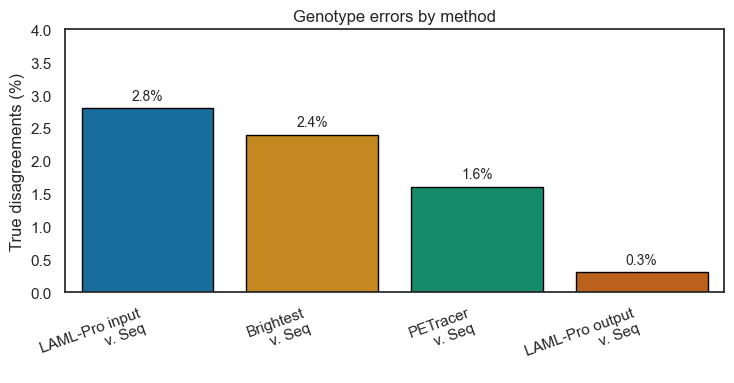

In [316]:
import matplotlib.pyplot as plt

data = {
    "Method": [
        "LAML-Pro input\nv. Seq",
        "Brightest\nv. Seq",
        "PETracer\nv. Seq",
        "LAML-Pro output\nv. Seq",
    ],
    "True_disagree_pct": [2.8, 2.4, 1.6, 0.3],  # percent values
}

df = pd.DataFrame(data)

# Optional: set an output path to save (e.g., "disagreements_bar.pdf" or .png)
outfile = f"{plotdir}/petracer_seqval_genotype_error.pdf"

# ---- Plot ----
sns.set_theme(style="white", context="notebook")
fig, ax = plt.subplots(figsize=(7.5, 4))

# Keep the given order; change to df.sort_values('True_disagree_pct') for sorting if desired
ax = sns.barplot(
    data=df,
    x="Method",
    y="True_disagree_pct",
    palette="colorblind",
    edgecolor="black"
)

ax.set_xlabel("")
ax.set_ylabel("True disagreements (%)")
ax.set_title("Genotype errors by method")

# Make space above tallest bar for labels
ymax = df["True_disagree_pct"].max()
ax.set_ylim(0, ymax * 1.25 + 0.5)

# Annotate each bar with its percentage
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.1f}%",
                (p.get_x() + p.get_width() / 2, height),
                ha="center", va="bottom",
                fontsize=10, xytext=(0, 4), textcoords="offset points")

# Improve x-label readability
plt.xticks(rotation=20, ha="right")

plt.tight_layout()

if outfile:
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
plt.show()

Two questions:
1. Do we impute correctly when there was missing data? What percentage was missing, and what did we impute? Could we impute where the sequencing missed? How much did the sequencing miss? 
2. Do we make genotype call changes correctly? Are we correcting PETracer?

In [330]:
print(f"We have {lp.shape[0]} cells and {lp.shape[1]} sites, for a total of {lp.shape[0] * lp.shape[1]} target sites.")

We have 153 cells and 60 sites, for a total of 9180 target sites.


In [331]:
print(f"Sequencing misses: {round(seq.eq(-1).sum().sum() / (seq.shape[0] * seq.shape[1]), 3) * 100}% of the target sites.")
print(f"Sequencing gave genotype calls at {(seq.to_numpy() != -1).sum()} sites ({round((seq.to_numpy() != -1).sum()/(seq.shape[0] * seq.shape[1]), 3)} of all sites).")

Sequencing misses: 20.4% of the target sites.
Sequencing gave genotype calls at 7308 sites (0.796 of all sites).


In [332]:
print(f"LAML-Pro imputed (non-silenced) genotypes at {(lp.to_numpy() != -1).sum()} sites ({round((lp.to_numpy() != -1).sum()/(lp.shape[0] * lp.shape[1]), 3)} of all sites).")

LAML-Pro imputed (non-silenced) genotypes at 7320 sites (0.797 of all sites).


##### LAML-Pro imputed exactly 12 target sites which even sequencing missed

In [333]:
plotdir = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots"

In [334]:
lp.index.names = ['cell_name']
seq.index.names = ['cell_name']

In [335]:
lp

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
cell_name,,,,,,,,,,,,,,,,,,,,,
4T1_preedited-35,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,8,-1,-1,-1,3,8,5,-1,-1,-1
4T1_preedited-7085,-1,-1,-1,-1,-1,-1,-1,-1,-1,8,...,-1,-1,-1,-1,3,8,5,-1,-1,-1
4T1_preedited-6334,-1,-1,-1,-1,-1,-1,8,1,7,8,...,-1,-1,-1,-1,3,8,5,-1,-1,-1
4T1_preedited-2074,-1,-1,-1,-1,-1,-1,8,1,7,8,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4T1_preedited-2716,2,4,2,-1,-1,-1,8,1,7,8,...,-1,-1,-1,-1,-1,-1,-1,8,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4T1_preedited-2369,2,4,2,-1,-1,-1,8,1,7,8,...,8,3,3,8,3,8,5,8,8,4
4T1_preedited-3465,-1,-1,-1,6,2,1,8,1,7,8,...,8,3,3,8,3,8,5,-1,-1,-1
4T1_preedited-6729,2,4,2,6,2,1,8,1,7,-1,...,8,3,3,8,-1,-1,-1,8,8,4


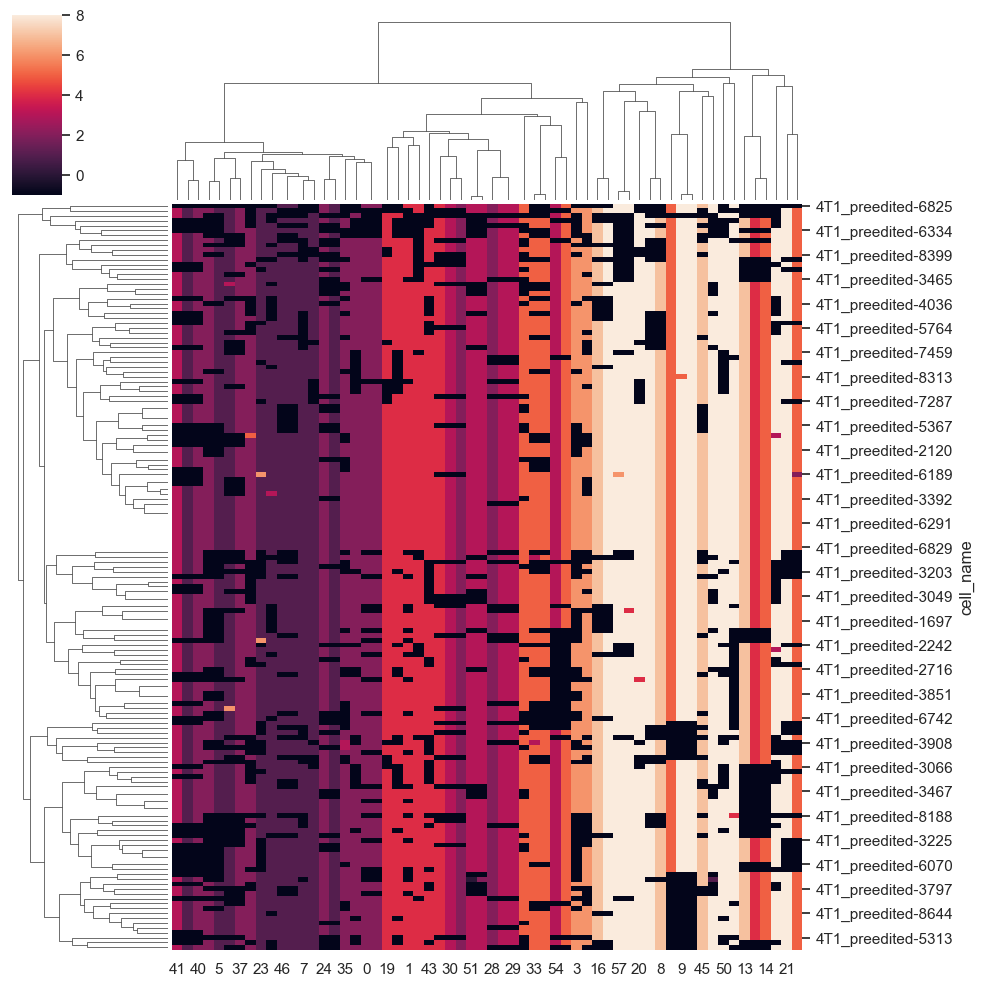

In [361]:
sns.clustermap(lp, row_cluster=True, col_cluster=True, metric="euclidean", method="complete")

In [362]:
g_lp = sns.clustermap(lp, row_cluster=True, col_cluster=True, metric="euclidean", method="complete")
row_order = g_lp.dendrogram_row.reordered_ind
col_order = g_lp.dendrogram_col.reordered_ind
Zc = g_lp.dendrogram_col.linkage
plt.close(g_lp.fig)

In [380]:
OKABE = ['grey', 'white',
         '#D55E00',  # reddish one (vermillion)
         '#E69F00',  # orange one
         '#F0E442',  # yellow one
         '#009E73',  # green/turquoise
         '#56B4E9',  # light blue
         '#0072B2',  # dark blue
         '#882255',  # deep magenta,
         '#CC79A7',   # light purple (magenta),
         '#332288',  # dark blue
        ]
from matplotlib.colors import ListedColormap, BoundaryNorm

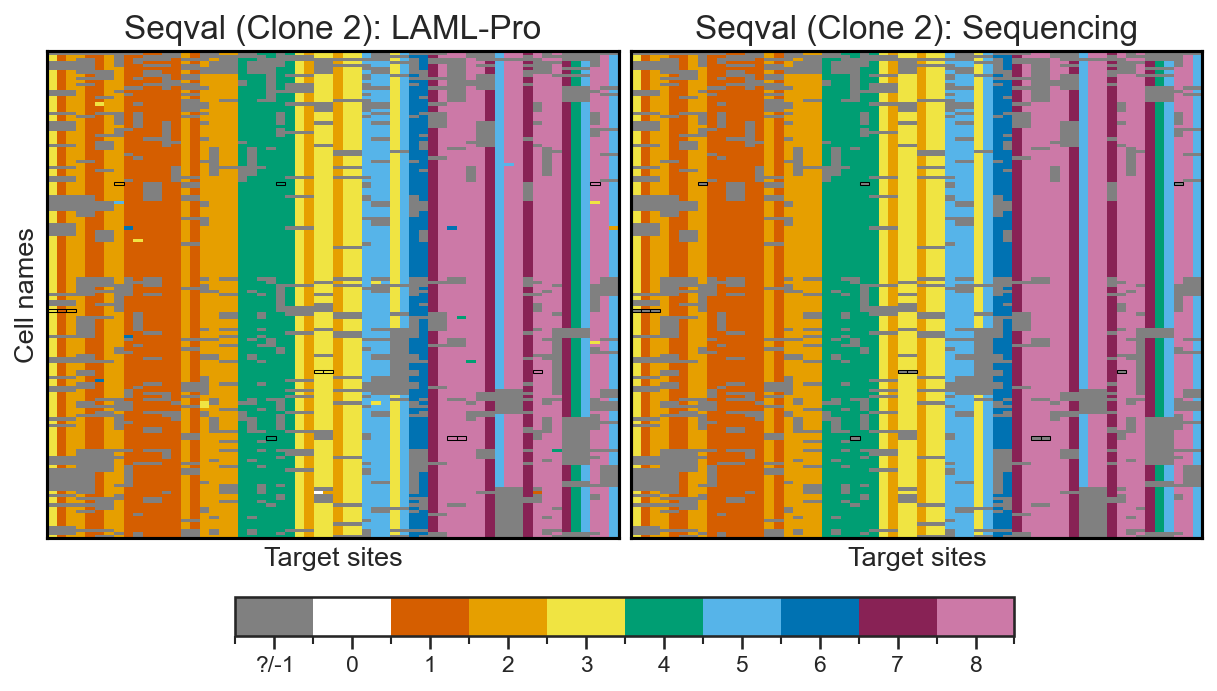

In [404]:
from matplotlib.patches import Rectangle

other = seq
other_method = "Sequencing"
title = "Seqval (Clone 2)"
outfile = f"{plotdir}/seqval_clone2_seq_vs_pet_genocomparison.pdf"
vmin, vmax = -1, 8

lp_ord = lp.iloc[row_order, :].iloc[:, col_order]
other_ord = other.iloc[row_order, :].iloc[:, col_order]

categories = np.arange(vmin, vmax + 1)
cmap   = ListedColormap(OKABE[:len(categories)])
cmap.set_bad(OKABE[0])
bounds = np.arange(vmin - 0.5, vmax + 1.5, 1.0)
norm   = BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(1, 2, figsize=(8, 4.5), dpi=150, constrained_layout=True)

# LEFT: LAML-Pro
sns.heatmap(
    lp_ord, ax=axes[0], cmap=cmap, norm=norm, vmin=vmin, vmax=vmax,
    xticklabels=False, yticklabels=False, cbar=False, rasterized=False
)
axes[0].set_title(f"{title}: LAML-Pro", fontsize=16)
axes[0].set_xlabel("Target sites", fontsize=13)
axes[0].set_ylabel("Cell names", fontsize=13)
axes[0].tick_params(axis="both", labelsize=11)

# RIGHT: Sequencing
sns.heatmap(
    other_ord, ax=axes[1], cmap=cmap, norm=norm, vmin=vmin, vmax=vmax,
    xticklabels=False, yticklabels=False, cbar=False, rasterized=False
)
axes[1].set_title(f"{title}: {other_method}", fontsize=16)
axes[1].set_xlabel("Target sites", fontsize=13)
axes[1].set_ylabel("")
axes[1].tick_params(axis="both", labelsize=11)

# Panel borders
for ax in axes:
    for side in ("left", "right", "top", "bottom"):
        ax.spines[side].set_visible(True)
        ax.spines[side].set_linewidth(1.5)
        ax.spines[side].set_edgecolor("black")

# === Outline (no fill) where (lp != -1) & (seq == -1) ===
cond = (lp_ord.values != -1) & (other_ord.values == -1)
rows, cols = np.where(cond)

def _outline_cells(ax, rows, cols, color="black", lw=0.5):
    for i, j in zip(rows, cols):
        ax.add_patch(
            Rectangle(
                (j, i), 1, 1, fill=False, edgecolor=color, linewidth=lw,
                zorder=5, clip_on=False, joinstyle="miter"
            )
        )

# Draw outlines on BOTH panels
_outline_cells(axes[0], rows, cols, color="black", lw=0.5)  # LAML-Pro panel (left)
_outline_cells(axes[1], rows, cols, color="black", lw=0.5)  # Sequencing panel (right)

# Shared colorbar
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes,
    orientation="horizontal", fraction=0.08, pad=0.05
)
cbar.set_ticks(categories)
cbar.set_ticklabels(["?/-1" if x == -1 else str(x) for x in categories])

fig.savefig(outfile, bbox_inches="tight", dpi=150)


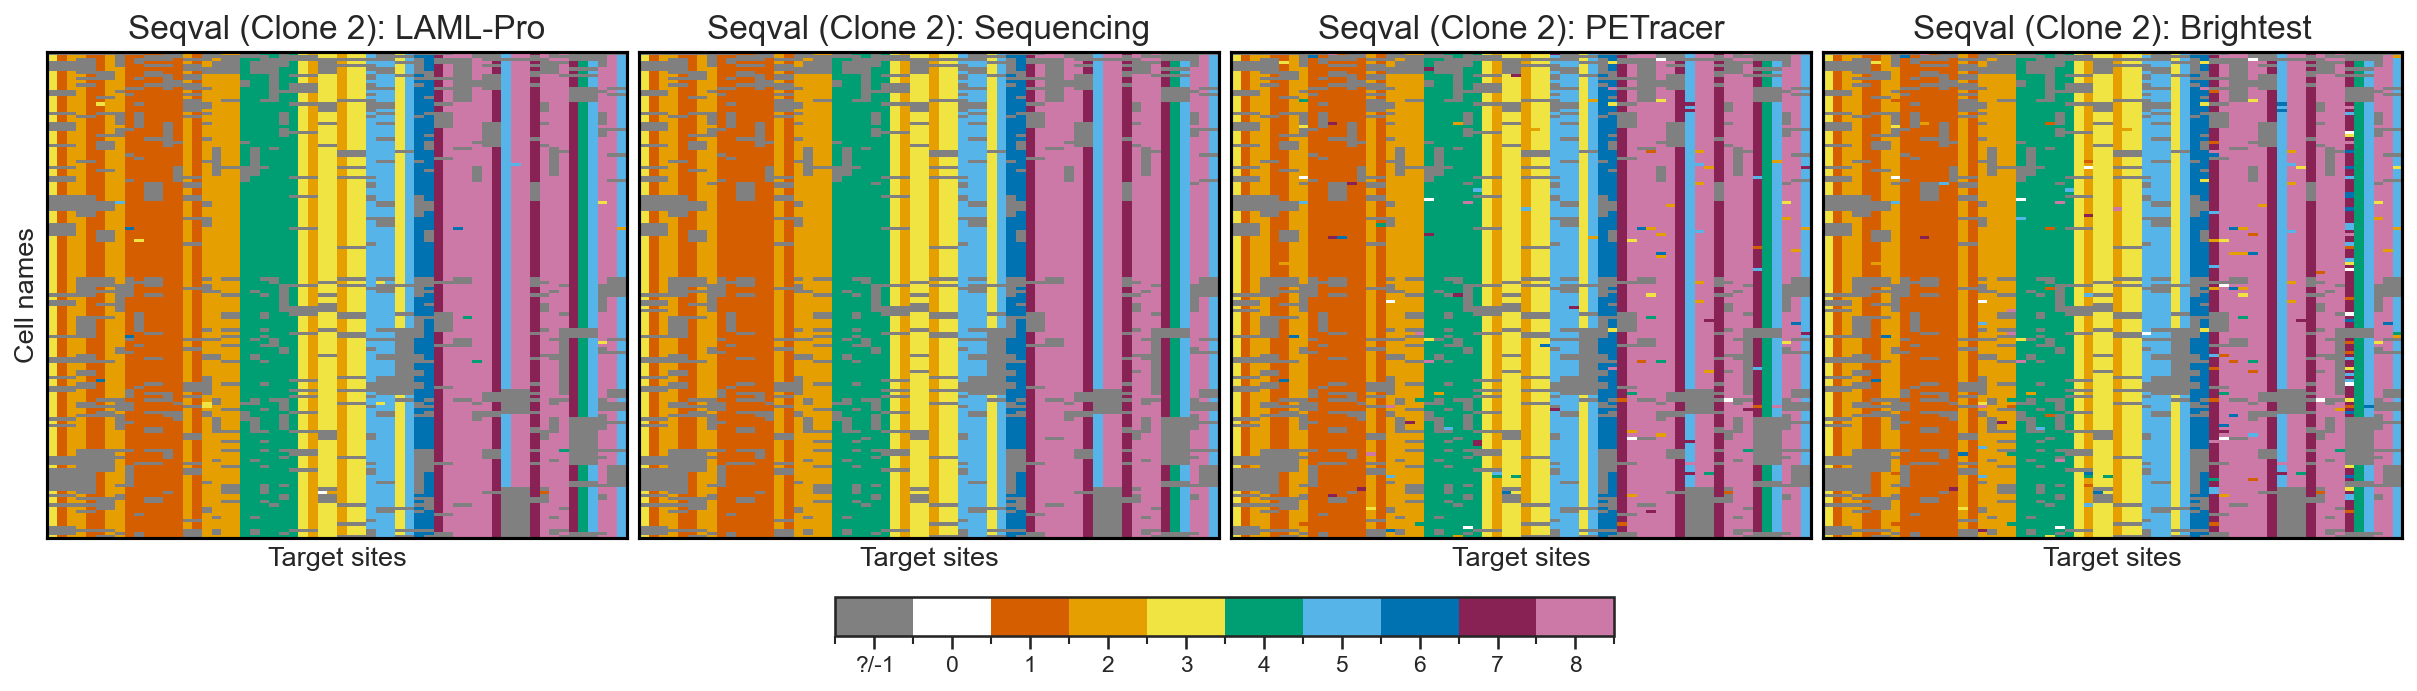

In [403]:
mats = [lp, seq, pet, bright]  # e.g., [PETracer_df, LAMLPro_df]
labels = ["LAML-Pro", "Sequencing", "PETracer", "Brightest"]
fig, axes = plot_genotype_panels(
    mats=mats,
    labels=labels,
    title="Seqval (Clone 2)",
    outfile=f"{plotdir}/seqval_clone2_all_genocomparison.pdf",
    row_order=row_order,
    col_order=col_order,
    vmin=-1, vmax=8,
    missing_code=-1,
    show_ticks=False,       # set True if you want tick labels
    rasterized=False
)
